Проверка качества фотографий с помощью обученной модели yolov8l для детекции терминалов.

# Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import torch
import random
import os
from pathlib import Path
from tqdm import tqdm
from ultralytics import YOLO
from IPython.display import clear_output
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
seed =100
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Проверка качества модели на случайных фото

In [3]:
df = pd.read_pickle('../data/common_files/df_markup.pkl')

In [4]:
df_terminal = df.loc[
    (df['terminal']==1) &
    (df['file_name'].apply(lambda x: 'augm' not in x))
].copy()

In [5]:
random_photos = df_terminal.sample(100)['file_name']

In [6]:
val_folder = Path('val_photos')
if not os.path.exists(val_folder):
    os.makedirs(val_folder)

In [7]:
model = YOLO('best.pt')

In [8]:
# 100 random pics
for image_data in tqdm(random_photos):
    results = model.predict(image_data)
    fig, ax = plt.subplots(1, 2, figsize=(19, 10))
    im = Image.open(image_data)
    ax[0].imshow(im)
    ax[1].imshow(im)
    for i, box in enumerate(results[0].boxes):
        x1, y1, x2, y2 = box.xyxy[0].tolist()
        cls = int(box.cls)
        conf = float(box.conf)
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, linewidth=2, edgecolor='red')
        ax[1].add_patch(rect)
        ax[1].text(x1, y1 - 10, f'{results[0].names[int(cls)]} {(conf):.2f}', color='white', fontsize=9,
                bbox=dict(facecolor='red', alpha=0.5))
    ax[0].set_title(f"Original Image")
    ax[0].set_axis_off()
    ax[1].set_title('Terminal Detection')
    ax[1].set_axis_off()
    file_name = val_folder / image_data.split('\\')[-1]
    plt.savefig(file_name)
    plt.close(fig)
clear_output()

In [9]:
# all pictures val
sizes, s_rects, shares = [], [], []
for image_data in tqdm(df_terminal['file_name']):
    im = Image.open(image_data)
    results = model.predict(im)
    im_size = im.size
    sizes.append(im_size)
    s_rect = 0
    min_x, max_x = float('+inf'), float('-inf')
    min_y, max_y = float('+inf'), float('-inf')
    for i, box in enumerate(results[0].boxes):
        x1, y1, x2, y2 = box.xyxy[0].tolist()
        if x1 < min_x: min_x = x1
        if x2 > max_x: max_x = x2
        if y1 < min_y: min_y = y1
        if y2 > max_y: max_y = y2
        s_rect += abs(x1-x2) * abs(y1-y2)
    if s_rect > 1:
        s_rect = abs(min_x - max_x) * abs(min_y - max_y)
    s_rects.append(s_rect)
    shares.append(s_rect / (im_size[0] * im_size[1]))
clear_output()

In [10]:
x1, y1, x2, y2

(341.393310546875, 411.2955627441406, 1174.5286865234375, 1966.5411376953125)

In [11]:
df_shares = pd.DataFrame(
    {
        'file_name': df_terminal['file_name'],
        'im_size': sizes,
        's_rect': s_rects,
        'rect_share': shares
    }
)
df_shares.to_pickle('df_share.pkl')

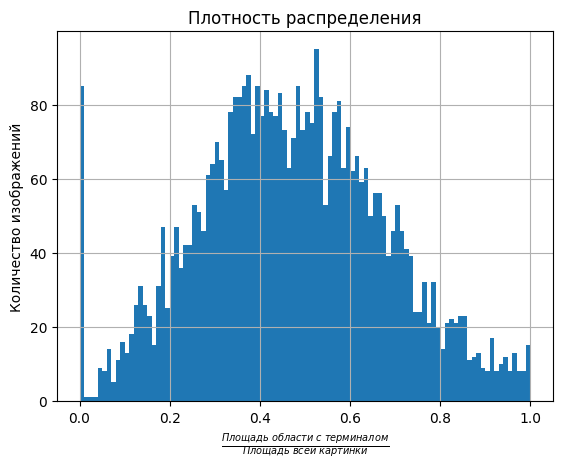

In [37]:
df_shares['rect_share'].hist(bins=100)
plt.title('Плотность распределения')
plt.xlabel(r"$\frac{Площадь\ области\ с\ терминалом}{Площадь\ всей\ картинки}$")
plt.ylabel('Количество изображений')
plt.show()

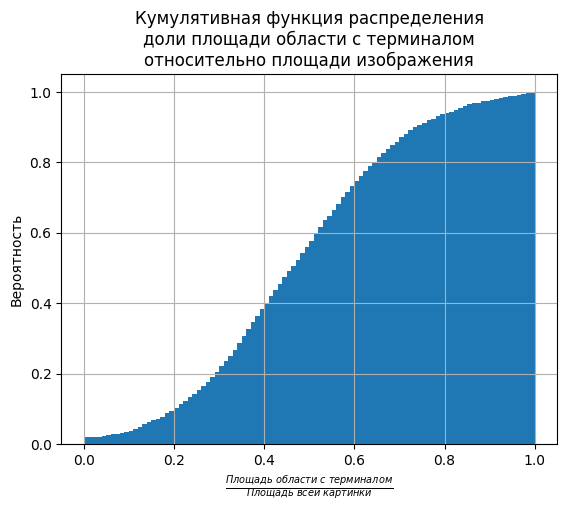

In [34]:
df_shares['rect_share'].hist(bins=100, cumulative=True, density=1)
plt.xlabel(r"$\frac{Площадь\ области\ с\ терминалом}{Площадь\ всей\ картинки}$")
plt.ylabel('Вероятность')
plt.title('Кумулятивная функция распределения\nдоли площади области с терминалом\nотносительно площади изображения')
plt.show()